In [2]:
import pandas as pd
import numpy as np
import glob
import os
import re
import warnings
import matplotlib.pyplot as plt

from utils.filters import  filter_days_with_less_than_10_rows, high_pass_filter
from utils.multimodal_preprocessing.acc_gyro_processing import process_acc_gyro
from utils.multimodal_preprocessing.led_processing import process_led
from utils.multimodal_preprocessing.temp_processing import process_temp

# Suppress specific warnings
warnings.filterwarnings("ignore", message="nperseg = .* is greater than input length")
warnings.filterwarnings("ignore", category=UserWarning, module="neurokit2")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# Define the folder containing the files
folder_path = "RestEaze_Data"

# Define the subject dictionary
filter_dict = {
    'adhd': {
        'KKI_001': {'left': {}, 'right': {}}, 'KKI_003': {'left': {}, 'right': {}},
        'KKI_004': {'left': {}, 'right': {}}, 'KKI_005': {'left': {}, 'right': {}},
        'KKI_006': {'left': {}, 'right': {}}, 'KKI_007': {'left': {}, 'right': {}},
        'KKI_008': {'left': {}, 'right': {}}, 'KKI_013': {'left': {}, 'right': {}},
        'KKI_014': {'left': {}, 'right': {}}, 'KKI_015': {'left': {}, 'right': {}},
        'KKI_016': {'left': {}, 'right': {}}, 'KKI_017': {'left': {}, 'right': {}},
        'KKI_018': {'right': {}}, 'KKI_020': {'left': {}}
    },
    'california': {
        '00000187': {'right': {}}, '00000189': {'right': {}}, '00000202': {'right': {}},
        '00000227': {'right': {}}, '00011946': {'right': {}}, '00011947': {'right': {}},
        '00011955': {'right': {}}, '00011970': {'right': {}}, '00011978': {'right': {}}
    }
}

# Define file patterns
pattern_california = os.path.join(folder_path, "*california*.csv")
pattern_ADHD = os.path.join(folder_path, "*adhd*.csv")

# Get file lists
files_california = glob.glob(pattern_california)
files_ADHD = glob.glob(pattern_ADHD)

# Combine both file lists
all_files = list(set(files_california + files_ADHD))

# Filter files based on the dictionary
filtered_files = []
for file_path in all_files:
    file_name = os.path.basename(file_path)
    
    # Match ADHD subjects
    match_adhd = re.search(r'adhd-KKI_(\d+)-(\w+)-sync\.csv', file_name)
    if match_adhd:
        subject_id, side = f"KKI_{match_adhd.group(1)}", match_adhd.group(2)
        if subject_id in filter_dict['adhd'] and side in filter_dict['adhd'][subject_id]:
            filtered_files.append(file_path)
        continue  # Move to the next file

    # Match California subjects
    match_california = re.search(r'california-(\d+)-(\w+)-sync\.csv', file_name)
    if match_california:
        subject_id, side = match_california.group(1), match_california.group(2)
        if subject_id in filter_dict['california'] and side in filter_dict['california'][subject_id]:
            filtered_files.append(file_path)

# Print filtered files
print("Filtered Files:", filtered_files)

# Initialize an empty list for dataframes
dataframes = []

# Process each filtered file
for file_path in filtered_files:
    print("Processing:", file_path)
    
    # Extract subject ID
    try:
        subject_id_match = re.search(r'(\d+)', os.path.basename(file_path))
        subject_id = subject_id_match.group(1) if subject_id_match else "Unknown"
    except Exception as e:
        print(f"Error extracting subject ID from {file_path}: {e}")
        continue

    # Read the CSV file
    try:
        data = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        continue

    # Convert unixTimes to datetime if necessary
    if 'unixTimes' in data.columns and 'datetime' not in data.columns:
        data['datetime'] = pd.to_datetime(data['unixTimes'], unit='ns')

    # Drop unnecessary columns
    data = data.drop(columns=[col for col in ['Unnamed: 0', 'counter'] if col in data.columns])

    # Add metadata columns
    data['subject_id'] = subject_id
    data['file'] = os.path.basename(file_path)
    #data['subject_id'] = os.path.basename(file_path)
    # Append dataframe
    dataframes.append(data)

# Concatenate all dataframes into one
if dataframes:
    final_dataframe = pd.concat(dataframes, ignore_index=True)
    print("Final dataframe created successfully.")
    final_dataframe.to_csv("filtered_final_dataframe.csv", index=False)
    print("Filtered dataframe saved to 'filtered_final_dataframe.csv'.")
else:
    print("No data matched the filtering criteria.")

In [49]:
#final_dataframe = pd.read_csv("filtered_final_dataframe.csv")
final_dataframe = final_dataframe[final_dataframe["sleep_stage"] != "NS"]
final_dataframe["subject_id"].unique()

array([   14, 11947,    18,     1,     5,    15,   202,     6, 11978,
         189,     7,     4,    16,    20,     8, 11946,     3,   187,
         227,    13,    17, 11970,   182, 11955], dtype=int64)

In [50]:
files_lower = final_dataframe["file"].str.lower()

# Vectorized boolean masks
is_left = files_lower.str.contains("left")
is_right = files_lower.str.contains("right")

# Preallocate subject_id as string
subject_str = final_dataframe["subject_id"].astype(str)

# Use np.select for speed
final_dataframe["subject_id"] = np.select(
    [is_left, is_right],
    [subject_str + "_left", subject_str + "_right"],
    default=subject_str
)

In [51]:
final_dataframe.head()

,unixTimes,accelerometerX,accelerometerY,accelerometerZ,capacitorsA,gyroscopeX,gyroscopeY,gyroscopeZ,ledIR,ledRed,...,Obstructive Apnea,Central Apnea,Leg Movement (L),Leg Movement (R),datetime,subject_id,file,capacitorsB,capacitorsC,sync
0,1722563124493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54654.0,81672.0,...,0,0,0,0,2024-08-02 01:45:24.493000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN
1,1722563124520,-2397.0,312.0,3237.0,60204.0,-92.0,-17.0,16.0,NaN,NaN,...,0,0,0,0,2024-08-02 01:45:24.520000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN
2,1722563124533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85492.0,103924.0,...,0,0,0,0,2024-08-02 01:45:24.533000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN
3,1722563124560,-2455.0,276.0,3220.0,60177.0,-36.0,12.0,5.0,NaN,NaN,...,0,0,0,0,2024-08-02 01:45:24.560000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN
4,1722563124573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85505.0,103915.0,...,0,0,0,0,2024-08-02 01:45:24.573000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN


In [52]:
for i in final_dataframe["sleep_stage"].unique():
    print(i)

WK
N1
N2
N3
REM
nan


In [53]:
# Create a new column 'state' based on 'sleep_stage'
final_dataframe["state"] = final_dataframe["sleep_stage"].apply(
    lambda x: "sleep" if x in ["N1", "N2", "N3", "REM"] else "awake"
)

In [54]:
final_dataframe["state"]

0           awake
1           awake
2           awake
3           awake
4           awake
            ...  
53087897    sleep
53087898    sleep
53087899    sleep
53087900    sleep
53087901    sleep
Name: state, Length: 51154579, dtype: object

In [55]:
# Apply the filtering to adhd_datasets directly
filter_days_with_less_than_10_rows(final_dataframe)

,unixTimes,accelerometerX,accelerometerY,accelerometerZ,capacitorsA,gyroscopeX,gyroscopeY,gyroscopeZ,ledIR,ledRed,...,Central Apnea,Leg Movement (L),Leg Movement (R),datetime,subject_id,file,capacitorsB,capacitorsC,sync,state
0,1722563124493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54654.0,81672.0,...,0,0,0,2024-08-02 01:45:24.493000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN,awake
1,1722563124520,-2397.0,312.0,3237.0,60204.0,-92.0,-17.0,16.0,NaN,NaN,...,0,0,0,2024-08-02 01:45:24.520000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN,awake
2,1722563124533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85492.0,103924.0,...,0,0,0,2024-08-02 01:45:24.533000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN,awake
3,1722563124560,-2455.0,276.0,3220.0,60177.0,-36.0,12.0,5.0,NaN,NaN,...,0,0,0,2024-08-02 01:45:24.560000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN,awake
4,1722563124573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85505.0,103915.0,...,0,0,0,2024-08-02 01:45:24.573000+00:00,14_left,adhd-KKI_014-left-sync.csv,NaN,NaN,NaN,awake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53087897,1706005894902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80297.0,103753.0,...,0,1,1,1970-01-01 00:28:26.005894902,5_right,adhd-KKI_005-right-sync.csv,NaN,NaN,NaN,sleep
53087898,1706005894937,-826.0,-1095.0,3803.0,32741.0,131.0,28.0,-87.0,NaN,NaN,...,0,1,1,1970-01-01 00:28:26.005894937,5_right,adhd-KKI_005-right-sync.csv,NaN,NaN,NaN,sleep
53087899,1706005894942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80300.0,103761.0,...,0,1,1,1970-01-01 00:28:26.005894942,5_right,adhd-KKI_005-right-sync.csv,NaN,NaN,NaN,sleep
53087900,1706005894977,-829.0,-1112.0,3801.0,32339.0,138.0,29.0,-79.0,NaN,NaN,...,0,1,1,1970-01-01 00:28:26.005894977,5_right,adhd-KKI_005-right-sync.csv,NaN,NaN,NaN,sleep


In [56]:
# Convert state to numeric: awake=1, sleep=0
final_dataframe["state"] = final_dataframe["state"].map({"awake": 1, "sleep": 0})

# Calculate WK count and ratio
wk_count = (final_dataframe["state"] == 1).sum()
total_count = len(final_dataframe)
wk_ratio = wk_count / total_count

print(f"WK Count: {wk_count}")
print(f"WK Ratio: {wk_ratio:.4f}")

WK Count: 8577062
WK Ratio: 0.1677


In [57]:
data = final_dataframe.copy()

In [58]:
# Calculate the missing ratio for each column
missing_ratios = data.isnull().sum() / len(data)

# Convert to percentage
missing_ratios = missing_ratios * 100

# Display the missing ratio for each column
missing_ratios.sort_values(ascending=False)

capacitorsC              100.000000
capacitorsB              100.000000
sync                     100.000000
tempAmbient               99.600716
tempObject                99.600716
ledIR                     50.575345
ledGreen                  50.575345
ledRed                    50.575345
gyroscopeX                49.823940
gyroscopeY                49.823940
gyroscopeZ                49.823940
accelerometerZ            49.823940
accelerometerX            49.823940
accelerometerY            49.823940
capacitorsA               49.823939
sleep_stage                0.010849
sleep_state                0.010849
subject_id                 0.000000
file                       0.000000
unixTimes                  0.000000
state                      0.000000
Leg Movement (R)           0.000000
datetime                   0.000000
Leg Movement               0.000000
Leg Movement (L)           0.000000
Central Apnea              0.000000
Obstructive Apnea          0.000000
Relative Desaturation      0

In [59]:
# List of columns to keep along with 'unixTimes'
columns_to_keep = [
    'unixTimes', 'accelerometerX', 'accelerometerY', 'accelerometerZ',
    'gyroscopeX', 'gyroscopeY',"Obstructive Apnea","Central Apnea",
    'gyroscopeZ', 'ledIR', 'ledRed', 'ledGreen', 'tempObject', 'tempAmbient',
    'state', 'sleep_state','subject_id'
]

# Select the specified columns only
data_filtered = data[columns_to_keep]

# Convert 'unixTimes' to datetime and set it as the first column
data_filtered['datetime'] = pd.to_datetime(data_filtered['unixTimes'], unit='ms')

# Reorder columns to place 'datetime' as the first column
columns_order = ['datetime'] + [col for col in data_filtered.columns if col != 'datetime']
data_filtered = data_filtered[columns_order]

# Display the updated DataFrame
data_filtered.head()


C:\Users\18319\AppData\Local\Temp\ipykernel_22284\652974977.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['datetime'] = pd.to_datetime(data_filtered['unixTimes'], unit='ms')


,datetime,unixTimes,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,Obstructive Apnea,Central Apnea,gyroscopeZ,ledIR,ledRed,ledGreen,tempObject,tempAmbient,state,sleep_state,subject_id
0,2024-08-02 01:45:24.493,1722563124493,NaN,NaN,NaN,NaN,NaN,0,0,NaN,54654.0,81672.0,4696.0,NaN,NaN,1,0.0,14_left
1,2024-08-02 01:45:24.520,1722563124520,-2397.0,312.0,3237.0,-92.0,-17.0,0,0,16.0,NaN,NaN,NaN,NaN,NaN,1,0.0,14_left
2,2024-08-02 01:45:24.533,1722563124533,NaN,NaN,NaN,NaN,NaN,0,0,NaN,85492.0,103924.0,4691.0,NaN,NaN,1,0.0,14_left
3,2024-08-02 01:45:24.560,1722563124560,-2455.0,276.0,3220.0,-36.0,12.0,0,0,5.0,NaN,NaN,NaN,NaN,NaN,1,0.0,14_left
4,2024-08-02 01:45:24.573,1722563124573,NaN,NaN,NaN,NaN,NaN,0,0,NaN,85505.0,103915.0,4689.0,NaN,NaN,1,0.0,14_left


In [60]:
data_filtered["subject_id"].unique()

array(['14_left', '11947_right', '18_right', '1_left', '5_left',
       '15_left', '202_right', '6_left', '11978_right', '189_right',
       '7_right', '15_right', '4_right', '16_left', '20_left', '7_left',
       '8_left', '6_right', '11946_right', '3_right', '3_left',
       '187_right', '227_right', '14_right', '8_right', '13_left',
       '17_right', '1_right', '11970_right', '16_right', '13_right',
       '4_left', '17_left', '182_right', '11955_right', '5_right'],
      dtype=object)

In [61]:
features = [
    'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ',
    "Obstructive Apnea","Central Apnea",'ledIR', 'ledRed', 'ledGreen', 'tempObject', 'tempAmbient','state'
]

In [62]:
# Apply the 99th percentile filtering and interpolate only removed points for each feature grouped by 'subject_id'
for subject_id, group in data_filtered.groupby('subject_id'):
    for col in data_filtered.columns:
        if col not in ['datetime', 'unixTimes', 'subject_id','tempObject','tempAmbient']:  # Skip non-numeric columns
            # Calculate the 99th percentile for the current feature within the group
            percentile_99 = group[col].quantile(0.9999)
            
            # Create a mask for points that will be removed
            removed_mask = group[col] > percentile_99
            
            # Apply the filter: set values above the 99th percentile to NaN
            data_filtered.loc[group.index, col] = group[col].where(~removed_mask, np.nan)
            
            # Interpolate only the removed points
            removed_points = data_filtered.loc[group.index, col][removed_mask]  # Keep track of removed points
            interpolated = removed_points.interpolate(method='linear', limit_direction='both')
            
            # Update only the removed points with interpolated values
            data_filtered.loc[interpolated.index, col] = interpolated

### Applying High Pass Filter

In [63]:
cutoff_freq = 0.2  # 0.2 Hz cutoff for the high-pass filter

In [64]:
# Features and sampling frequencies
sampling_frequencies = {
    'accelerometerX': 25,
    'accelerometerY': 25,
    'accelerometerZ': 25,
    'gyroscopeX': 25,
    'gyroscopeY': 25,
    'gyroscopeZ': 25,
    'state':25,
    'ledGreen': 25,
    'tempObject': None,
    'tempAmbient': None
}

In [65]:
# Define which features to apply filtering to
filter_features = [
    'accelerometerX', 'accelerometerY', 'accelerometerZ',
    'gyroscopeX', 'gyroscopeY', 'gyroscopeZ'
]

# Loop through each subject and apply the high-pass filter only to the selected features
for subject_id, group in data_filtered.groupby('subject_id'):
    for col in features:
        # Skip columns not in the filter_features list
        if col not in filter_features:
            continue

        # Check if the column exists and has a defined sampling frequency
        if col in group.columns and col in sampling_frequencies:
            fs = sampling_frequencies[col]

            if fs is not None:
                non_nan_data = group[col].dropna()

                if not non_nan_data.empty:
                    # Apply the high-pass filter
                    filtered_data = high_pass_filter(non_nan_data, cutoff=cutoff_freq, fs=fs)

                    # Create a Series with the filtered data using the same indices
                    filtered_series = pd.Series(data=filtered_data, index=non_nan_data.index)

                    # Update only the filtered (non-NaN) data points in the original DataFrame
                    data_filtered.loc[filtered_series.index, col] = filtered_series

In [66]:
# Dataset 1: Accelerometer and Gyroscope features
df_acc_gyro = data_filtered[['datetime', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 
                             'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', "Obstructive Apnea","Central Apnea",
                             'state', 'sleep_state', 'subject_id']].dropna(subset=[
    'accelerometerX', 'accelerometerY', 'accelerometerZ', 
    'gyroscopeX', 'gyroscopeY', 'gyroscopeZ'])

# Dataset 2: LED features
df_led = data_filtered[['datetime', 'ledIR', 'ledRed', 'ledGreen', "Obstructive Apnea","Central Apnea",
                        'state', 'sleep_state', 'subject_id']].dropna(subset=['ledIR', 'ledRed', 'ledGreen'])

# Dataset 3: Temperature features
df_temp = data_filtered[['datetime', 'tempObject', 'tempAmbient', "Obstructive Apnea","Central Apnea",
                         'state', 'sleep_state', 'subject_id']].dropna(subset=['tempObject', 'tempAmbient'])

In [67]:
# Calculate the overall ratio of each class in sleep_category
sleep_class_ratio = df_acc_gyro["state"].value_counts(normalize=True)

# Calculate the total count for each class
sleep_class_counts = df_acc_gyro["state"].value_counts()

# Combine the ratio and counts into a single DataFrame
sleep_summary = pd.DataFrame({
    "Ratio": sleep_class_ratio,
    "Total_Count": sleep_class_counts
})

# Display the overall ratios and counts
print("Overall ratio and total count of classes in sleep_category (after filtering):")
print(sleep_summary)

Overall ratio and total count of classes in sleep_category (after filtering):
      Ratio  Total_Count
0  0.832685     21361170
1  0.167315      4292190


### Processing Data Streams and Extracting Features

In [68]:
# Parameters
window_duration = 60 # Duration for processing windows in seconds
original_fs = 25  # Original sampling frequency
target_fs = 200   # Target sampling frequency
lowcut = 0.2     # Low-cut frequency in Hz
highcut = 5.0     # High-cut frequency in Hz
order = 2         # Butterworth filter order
# Example usage
fs = 25

In [69]:
df_processed_acc_gyro = process_acc_gyro(df_acc_gyro, window_duration, fs)
df_processed_temp = process_temp(df_temp, window_duration)
df_processed_led = process_led(df_led, window_duration, original_fs, target_fs, lowcut, highcut, order)

Processing subject_id: 11946_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 11947_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 11955_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 11970_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 11978_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 13_left in Accelerometer/Gyroscope Dataset...
Processing subject_id: 13_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 14_left in Accelerometer/Gyroscope Dataset...
Processing subject_id: 14_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 15_left in Accelerometer/Gyroscope Dataset...
Processing subject_id: 15_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 16_left in Accelerometer/Gyroscope Dataset...
Processing subject_id: 16_right in Accelerometer/Gyroscope Dataset...
Processing subject_id: 17_left in Accelerometer/Gyroscope Dataset...
Processing

In [70]:
# 1) Deduplicate columns (keep the first occurrence)
for name in ("df_processed_temp", "df_processed_acc_gyro"):
    df = globals()[name]
    if df.columns.duplicated().any():
        globals()[name] = df.loc[:, ~df.columns.duplicated()].copy()

# 2) Ensure datetime is proper dtype and align on subject too
df_processed_temp["datetime"] = pd.to_datetime(df_processed_temp["datetime"])
df_processed_acc_gyro["datetime"] = pd.to_datetime(df_processed_acc_gyro["datetime"])

# 3) Merge on both subject_id and datetime to avoid cross-subject mixing
merged_df = pd.merge(
    df_processed_temp,
    df_processed_acc_gyro,
    on=["subject_id", "datetime"],
    suffixes=('_temp', '_acc_gyro'),
    how="outer"    # or "outer" if you want union of timestamps
)

In [71]:
df_processed_temp = df_processed_temp.drop(
    columns=["state_mean", "Obstructive_Apnea_mean", "Central_Apnea_mean"],
    errors="ignore"
)

df_processed_led = df_processed_led.drop(
    columns=["state_mean", "Obstructive_Apnea_mean", "Central_Apnea_mean"],
    errors="ignore"
)

In [72]:
# Step 1: Merge DataFrames
merged_data = pd.merge(
    df_processed_acc_gyro,
    df_processed_temp,
    on=['datetime', 'subject_id'],
    how='outer'  # Merge all data, keeping missing rows
)

# Merge LED data as well
merged_data = pd.merge(
    merged_data,
    df_processed_led,
    on=['datetime', 'subject_id'],
    how='outer'
)

In [73]:
print(f"Shape of the dataset: {merged_data.shape}")

Shape of the dataset: (17182, 190)


### Checking for Missing Data Ratio

In [74]:
# Calculate the number of missing values per feature
missing_values_count = merged_data.isnull().sum()

# Calculate the percentage of missing values per feature
missing_values_percentage = (merged_data.isnull().sum() / len(merged_data)) * 100

# Combine both into a DataFrame for better visualization
missing_data = pd.DataFrame({
    'Missing Values': missing_values_count,
    'Percentage (%)': missing_values_percentage
})

# Sort the DataFrame by percentage of missing values in descending order
missing_data_sorted = missing_data.sort_values(by='Percentage (%)', ascending=False)

print("Missing Values per Feature:\n", missing_data_sorted)

Missing Values per Feature:
                          Missing Values  Percentage (%)
HRV_SDANN2                        17182           100.0
HRV_SDANN1                        17182           100.0
HRV_SDANN5                        17182           100.0
HRV_SDNNI2                        17182           100.0
HRV_SDNNI1                        17182           100.0
...                                 ...             ...
gyroscopeY_datetime                   0             0.0
datetime                              0             0.0
accelerometerZ_datetime               0             0.0
subject_id                            0             0.0
accelerometerY_datetime               0             0.0

[190 rows x 2 columns]


In [75]:
missing_data_sorted.head(50)

,Missing Values,Percentage (%)
HRV_SDANN2,17182,100.000000
HRV_SDANN1,17182,100.000000
HRV_SDANN5,17182,100.000000
HRV_SDNNI2,17182,100.000000
HRV_SDNNI1,17182,100.000000
HRV_SDNNI5,17182,100.000000
HRV_VLF,17182,100.000000
HRV_ULF,17182,100.000000
HRV_CMSEn,2294,13.351181
HRV_RCMSEn,2294,13.351181


In [76]:
# Filter columns with missing percentage > 40%
columns_to_drop = missing_data_sorted[missing_data_sorted['Percentage (%)'] > 40].index

# Drop those columns
merged_data = merged_data.drop(columns=columns_to_drop)

# Get the names of the dropped columns
dropped_columns = list(columns_to_drop)

# Calculate counts
num_dropped = len(dropped_columns)
num_remaining = len(merged_data.columns)

# Output results
print(f"Columns dropped ({num_dropped}): {dropped_columns}")
print(f"Number of columns remaining: {num_remaining}")

Columns dropped (8): ['HRV_SDANN2', 'HRV_SDANN1', 'HRV_SDANN5', 'HRV_SDNNI2', 'HRV_SDNNI1', 'HRV_SDNNI5', 'HRV_VLF', 'HRV_ULF']
Number of columns remaining: 182


In [77]:
# Print column names of the DataFrame
print("Column names in merged_data:")
print(merged_data.columns.tolist())


Column names in merged_data:
['accelerometerX_mean', 'accelerometerX_median', 'accelerometerX_std', 'accelerometerX_var', 'accelerometerX_min', 'accelerometerX_max', 'accelerometerX_range', 'accelerometerX_skew', 'accelerometerX_kurtosis', 'accelerometerX_dominant_freq', 'accelerometerX_spectral_entropy', 'accelerometerX_rms_max', 'accelerometerX_rms_auc', 'accelerometerX_datetime', 'accelerometerY_mean', 'accelerometerY_median', 'accelerometerY_std', 'accelerometerY_var', 'accelerometerY_min', 'accelerometerY_max', 'accelerometerY_range', 'accelerometerY_skew', 'accelerometerY_kurtosis', 'accelerometerY_dominant_freq', 'accelerometerY_spectral_entropy', 'accelerometerY_rms_max', 'accelerometerY_rms_auc', 'accelerometerY_datetime', 'accelerometerZ_mean', 'accelerometerZ_median', 'accelerometerZ_std', 'accelerometerZ_var', 'accelerometerZ_min', 'accelerometerZ_max', 'accelerometerZ_range', 'accelerometerZ_skew', 'accelerometerZ_kurtosis', 'accelerometerZ_dominant_freq', 'accelerometerZ_

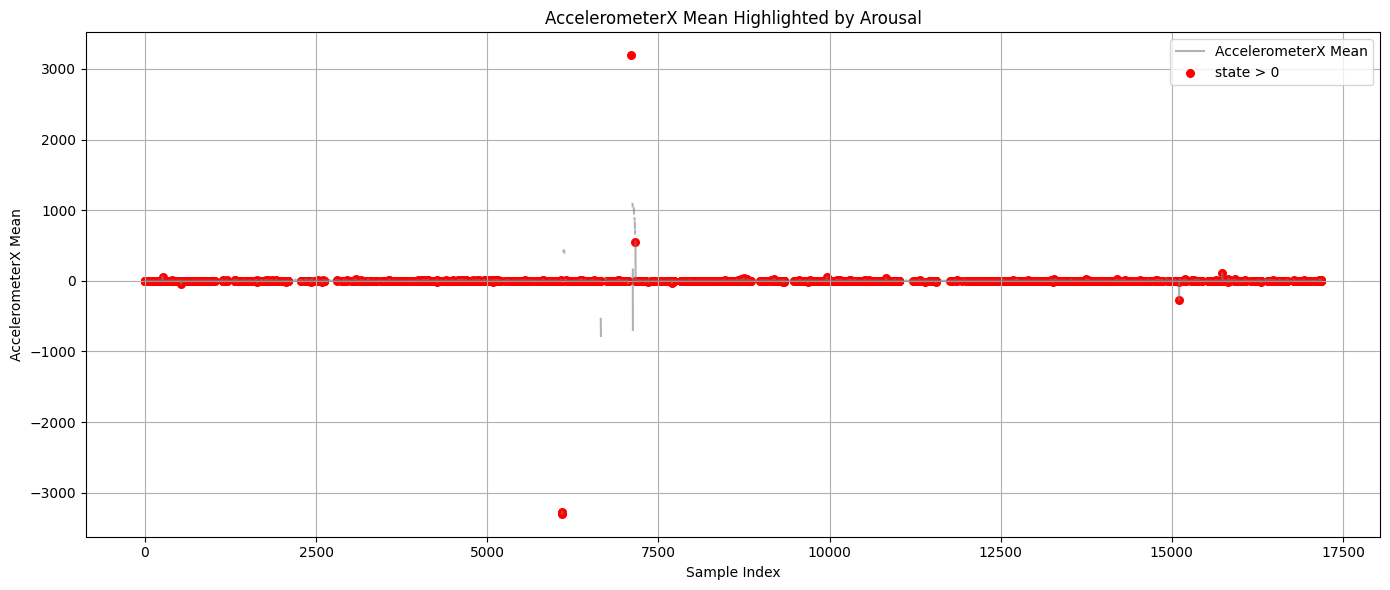

In [78]:
# --- Create binary labels based on Arousal_mean ---
merged_data['state_binary'] = np.where(merged_data['state_mean'] > 0, 1, 0)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index, merged_data['accelerometerX_mean'], color='gray', alpha=0.6, label='AccelerometerX Mean')

# --- Highlight segments where Arousal_mean > 0 ---
plt.scatter(
    merged_data.index[merged_data['state_binary'] == 1],
    merged_data['accelerometerX_mean'][merged_data['state_binary'] == 1],
    color='red', label='state > 0', s=30
)

plt.title('AccelerometerX Mean Highlighted by Arousal')
plt.xlabel('Sample Index')
plt.ylabel('AccelerometerX Mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
# Calculate the number of missing values for each row
row_missing_values = merged_data.isnull().sum(axis=1)

# Drop rows where the number of missing values is greater than 50
cleaned_data = merged_data[row_missing_values <= 50]

# Output the new DataFrame dimensions
print(f"Original number of rows: {len(merged_data)}")
print(f"Number of rows dropped: {len(merged_data) - len(cleaned_data)}")
print(f"Remaining number of rows: {len(cleaned_data)}")

merged_data= cleaned_data.copy()

Original number of rows: 17182
Number of rows dropped: 1635
Remaining number of rows: 15547


In [80]:
merged_data['subject_id'].unique()

array(['11946_right', '11947_right', '11955_right', '11970_right',
       '11978_right', '13_left', '13_right', '14_left', '14_right',
       '15_left', '15_right', '16_left', '16_right', '17_left',
       '17_right', '182_right', '187_right', '189_right', '18_right',
       '1_left', '1_right', '202_right', '20_left', '227_right', '3_left',
       '3_right', '4_left', '4_right', '5_left', '5_right', '6_left',
       '6_right', '7_left', '7_right', '8_left', '8_right'], dtype=object)

In [81]:
# Arousal category (binary: presence vs. absence)
filtered_df = merged_data.copy()
filtered_df["state_category"] = (filtered_df["state_mean"] > 0).astype(int)

In [82]:
# Calculate the overall ratio of each class in Arousal_category
arousal_class_ratio = filtered_df["state_category"].value_counts(normalize=True)

# Calculate the total count for each class
arousal_class_counts = filtered_df["state_category"].value_counts()

# Combine the ratio and counts into a single DataFrame
arousal_summary = pd.DataFrame({
    "Ratio": arousal_class_ratio,
    "Total_Count": arousal_class_counts
})

# Display the overall ratios and counts
print("Overall ratio and total count of classes in Arousal_category (after filtering):")
print(arousal_summary)


Overall ratio and total count of classes in Arousal_category (after filtering):
      Ratio  Total_Count
0  0.792757        12325
1  0.207243         3222


In [83]:
# Calculate the ratio of each class in Arousal_category
arousal_class_ratio = filtered_df["state_category"].value_counts(normalize=True)

# Display the class ratios
print("Ratio of classes in state_category:")
print(arousal_class_ratio)


Ratio of classes in state_category:
0    0.792757
1    0.207243
Name: state_category, dtype: float64


In [84]:
# Display all column names
print("Column names in filtered_df:")
for col in filtered_df.columns:
    print(col)

Column names in filtered_df:
accelerometerX_mean
accelerometerX_median
accelerometerX_std
accelerometerX_var
accelerometerX_min
accelerometerX_max
accelerometerX_range
accelerometerX_skew
accelerometerX_kurtosis
accelerometerX_dominant_freq
accelerometerX_spectral_entropy
accelerometerX_rms_max
accelerometerX_rms_auc
accelerometerX_datetime
accelerometerY_mean
accelerometerY_median
accelerometerY_std
accelerometerY_var
accelerometerY_min
accelerometerY_max
accelerometerY_range
accelerometerY_skew
accelerometerY_kurtosis
accelerometerY_dominant_freq
accelerometerY_spectral_entropy
accelerometerY_rms_max
accelerometerY_rms_auc
accelerometerY_datetime
accelerometerZ_mean
accelerometerZ_median
accelerometerZ_std
accelerometerZ_var
accelerometerZ_min
accelerometerZ_max
accelerometerZ_range
accelerometerZ_skew
accelerometerZ_kurtosis
accelerometerZ_dominant_freq
accelerometerZ_spectral_entropy
accelerometerZ_rms_max
accelerometerZ_rms_auc
accelerometerZ_datetime
gyroscopeX_mean
gyroscopeX_me

In [85]:
# Assuming 'final_df' is your DataFrame
class_counts = filtered_df['state_category'].value_counts()
class_ratios = filtered_df['state_category'].value_counts(normalize=True) * 100

print("Class Counts:\n", class_counts)
print("\nClass Ratios (%):\n", class_ratios)

Class Counts:
 0    12325
1     3222
Name: state_category, dtype: int64

Class Ratios (%):
 0    79.275745
1    20.724255
Name: state_category, dtype: float64


In [86]:
# Assuming 'final_df' is your DataFrame

# Calculate the percentage of missing values for each feature
missing_percentage = filtered_df.isnull().mean() * 100

# Identify features with more than 50% missing values
features_to_drop = missing_percentage[missing_percentage > 50].index

# Drop these features from the DataFrame
final_df_cleaned = filtered_df.drop(columns=features_to_drop)

print(f"Features dropped: {list(features_to_drop)}")
print(f"Remaining features: {final_df_cleaned.columns.tolist()}")

Features dropped: []
Remaining features: ['accelerometerX_mean', 'accelerometerX_median', 'accelerometerX_std', 'accelerometerX_var', 'accelerometerX_min', 'accelerometerX_max', 'accelerometerX_range', 'accelerometerX_skew', 'accelerometerX_kurtosis', 'accelerometerX_dominant_freq', 'accelerometerX_spectral_entropy', 'accelerometerX_rms_max', 'accelerometerX_rms_auc', 'accelerometerX_datetime', 'accelerometerY_mean', 'accelerometerY_median', 'accelerometerY_std', 'accelerometerY_var', 'accelerometerY_min', 'accelerometerY_max', 'accelerometerY_range', 'accelerometerY_skew', 'accelerometerY_kurtosis', 'accelerometerY_dominant_freq', 'accelerometerY_spectral_entropy', 'accelerometerY_rms_max', 'accelerometerY_rms_auc', 'accelerometerY_datetime', 'accelerometerZ_mean', 'accelerometerZ_median', 'accelerometerZ_std', 'accelerometerZ_var', 'accelerometerZ_min', 'accelerometerZ_max', 'accelerometerZ_range', 'accelerometerZ_skew', 'accelerometerZ_kurtosis', 'accelerometerZ_dominant_freq', 'acc

In [87]:
from sklearn.impute import KNNImputer

# Replace infinity values with NaN
final_df_cleaned = final_df_cleaned.replace([np.inf, -np.inf], np.nan)

# Check for excessively large values
max_threshold = 1e10  # Define a threshold for "too large" values
final_df_cleaned = final_df_cleaned.applymap(lambda x: np.nan if isinstance(x, (int, float)) and abs(x) > max_threshold else x)

# Separate numerical and non-numerical columns
numerical_columns = final_df_cleaned.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = final_df_cleaned.select_dtypes(exclude=['float64', 'int64']).columns

# Apply KNN Imputer to numerical columns
imputer = KNNImputer(n_neighbors=5)
numerical_data = final_df_cleaned[numerical_columns]

# Perform KNN imputation
numerical_data_imputed = imputer.fit_transform(numerical_data)

# Convert the imputed array back to a DataFrame
numerical_data_imputed_df = pd.DataFrame(numerical_data_imputed, columns=numerical_columns, index=final_df_cleaned.index)

# Combine the imputed numerical data with non-numerical data
final_df_imputed = pd.concat([numerical_data_imputed_df, final_df_cleaned[non_numerical_columns]], axis=1)

# Check the output
print("Imputation completed successfully.")
print(final_df_imputed.head())

Imputation completed successfully.
   accelerometerX_mean  accelerometerX_median  accelerometerX_std  \
2             0.000145              -0.075091            5.097747   
5            -0.012931              -0.154352            4.955032   
6            -0.011975              -0.043688            5.061650   
7             0.016565              -0.016283            5.029890   
8             0.006283              -0.107551            5.050960   

   accelerometerX_var  accelerometerX_min  accelerometerX_max  \
2           25.987022          -14.541364           18.385653   
5           24.552347          -16.329235           15.453756   
6           25.620300          -14.202904           17.107762   
7           25.299795          -17.027546           16.288277   
8           25.512196          -23.160460           17.748202   

   accelerometerX_range  accelerometerX_skew  accelerometerX_kurtosis  \
2             32.927017             0.041052                 0.111600   
5            

In [88]:
final_df_imputed = final_df_imputed.drop(columns=['datetime','Arousal_mean'], errors='ignore')

### Standardizing Features per Subject and Selecting Top Predictors

Standardizing features within each subject...
Feature standardization complete.
Selecting top 20 features using ANOVA F-value...
Top 20 Selected Features: ['accelerometerX_std', 'accelerometerX_max', 'accelerometerX_rms_max', 'accelerometerX_rms_auc', 'accelerometerY_max', 'gyroscopeX_max', 'gyroscopeX_spectral_entropy', 'gyroscopeX_rms_max', 'gyroscopeX_rms_auc', 'gyroscopeY_std', 'gyroscopeY_max', 'gyroscopeY_range', 'gyroscopeY_rms_max', 'gyroscopeY_rms_auc', 'gyroscopeZ_max', 'gyroscopeZ_spectral_entropy', 'state_mean', 'HRV_CVNN', 'HRV_CVI', 'state_binary']


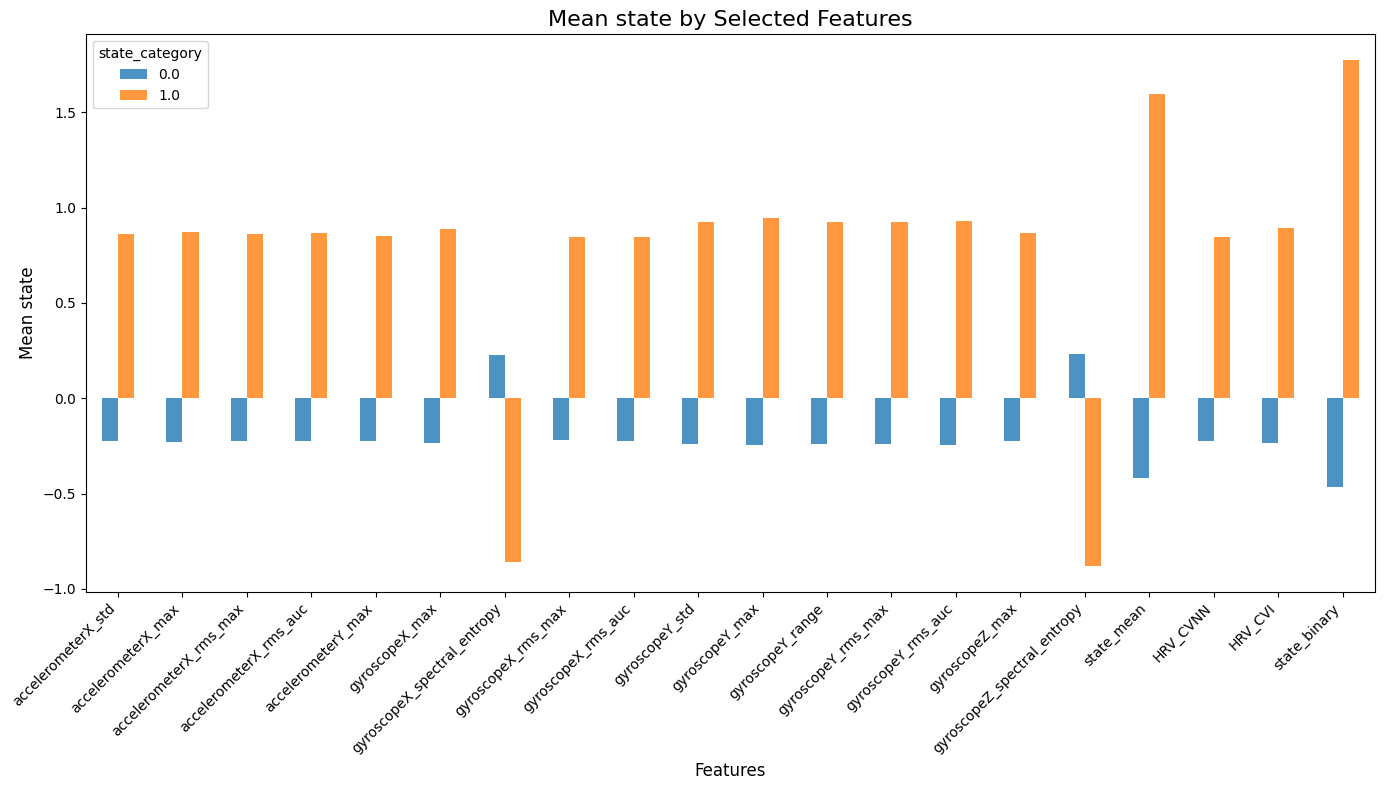

In [89]:
from sklearn.feature_selection import SelectKBest, f_classif

# Features and target (provided by user)
X = final_df_imputed.drop(columns=['state_category','subject_id'])
y = final_df_imputed['state_category']
groups = final_df_imputed['subject_id']  # Group by subject_id

# Standardize features within each subject
print("Standardizing features within each subject...")
X_standardized = X.copy()
for col in X.columns:
    X_standardized[col] = X.groupby(groups)[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
    )
print("Feature standardization complete.")

# SelectKBest for Feature Selection
k = 20  # Number of top features to select
print(f"Selecting top {k} features using ANOVA F-value...")
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_standardized, y)
selected_features = X.columns[selector.get_support()]
print(f"Top {k} Selected Features: {selected_features.tolist()}")

# Create a new DataFrame with selected features and Arousal_category
data_for_plot = pd.DataFrame(X_selected, columns=selected_features)
data_for_plot['state_category'] = y.values  # Add the target variable

# Calculate mean of `Arousal_category` grouped by features
feature_means = data_for_plot.groupby('state_category').mean()

# Plot mean of `Arousal_category` across selected features
fig, ax = plt.subplots(figsize=(14, 8))

# Transpose to ensure features are on the x-axis
feature_means.T.plot(kind='bar', ax=ax, alpha=0.8)

# Customize the plot
ax.set_title('Mean state by Selected Features', fontsize=16)
ax.set_ylabel('Mean state', fontsize=12)
ax.set_xlabel('Features', fontsize=12)
ax.set_xticks(range(len(selected_features)))
ax.set_xticklabels(selected_features, rotation=45, ha='right')

plt.tight_layout()
plt.show()

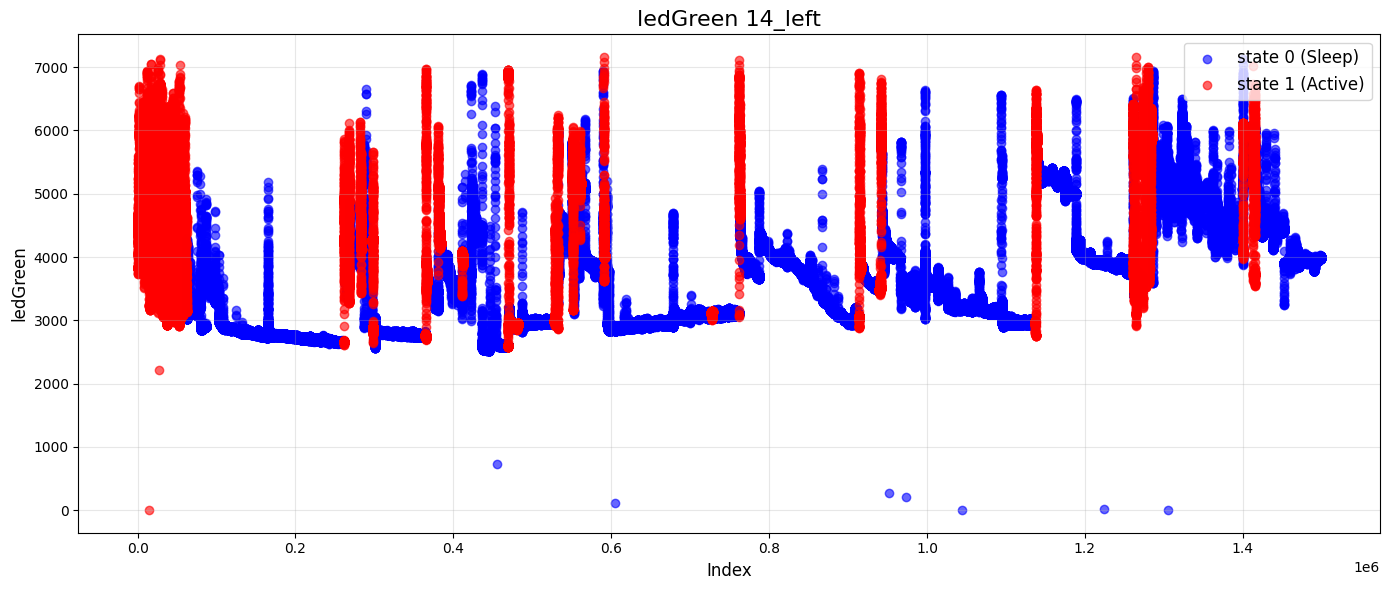

In [90]:
# Define the groups variable again
groups = df_led['subject_id']

# Filter data for the selected subject
selected_subject_id = groups.iloc[0]
subject_data = df_led[df_led['subject_id'] == selected_subject_id]

# Plot the ledGreen feature with different colors for arousal states
plt.figure(figsize=(14, 6))

# Scatter plot for state 0
plt.scatter(
    subject_data[subject_data['state'] == 0].index,
    subject_data[subject_data['state'] == 0]['ledGreen'],
    color='blue', label='state 0 (Sleep)', alpha=0.6
)

# Scatter plot for state 1
plt.scatter(
    subject_data[subject_data['state'] == 1].index,
    subject_data[subject_data['state'] == 1]['ledGreen'],
    color='red', label='state 1 (Active)', alpha=0.6
)

# Add labels, title, and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('ledGreen', fontsize=12)
plt.title(f'ledGreen {selected_subject_id}', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

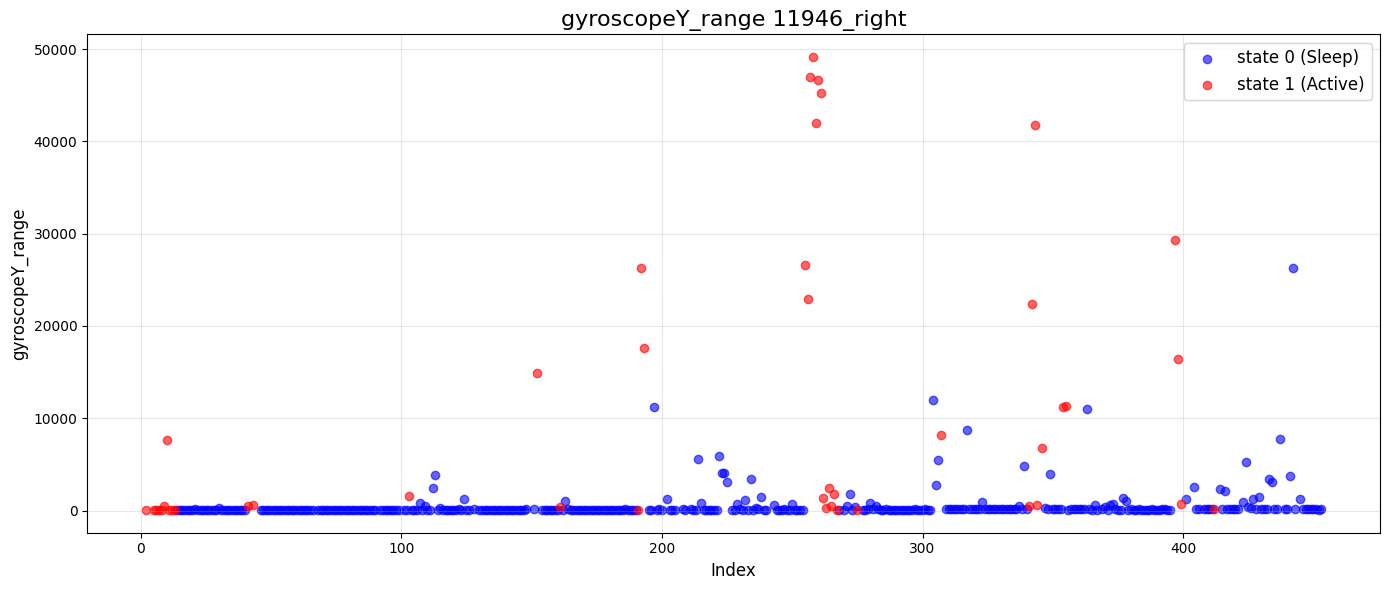

In [91]:
# Define the groups variable again
groups = final_df_imputed['subject_id']

# Filter data for the selected subject
selected_subject_id = groups.iloc[0]
subject_data = final_df_imputed[final_df_imputed['subject_id'] == selected_subject_id]

# Plot the accelerometerX_rms_auc with different colors for arousal states
plt.figure(figsize=(14, 6))

# Scatter plot for state 0
plt.scatter(
    subject_data[subject_data['state_category'] == 0].index,
    subject_data[subject_data['state_category'] == 0]['gyroscopeY_range'],
    color='blue', label='state 0 (Sleep)', alpha=0.6
)

# Scatter plot for state 1
plt.scatter(
    subject_data[subject_data['state_category'] == 1].index,
    subject_data[subject_data['state_category'] == 1]['gyroscopeY_range'],
    color='red', label='state 1 (Active)', alpha=0.6
)

# Add labels, title, and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('gyroscopeY_range', fontsize=12)
plt.title(f'gyroscopeY_range {selected_subject_id}', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

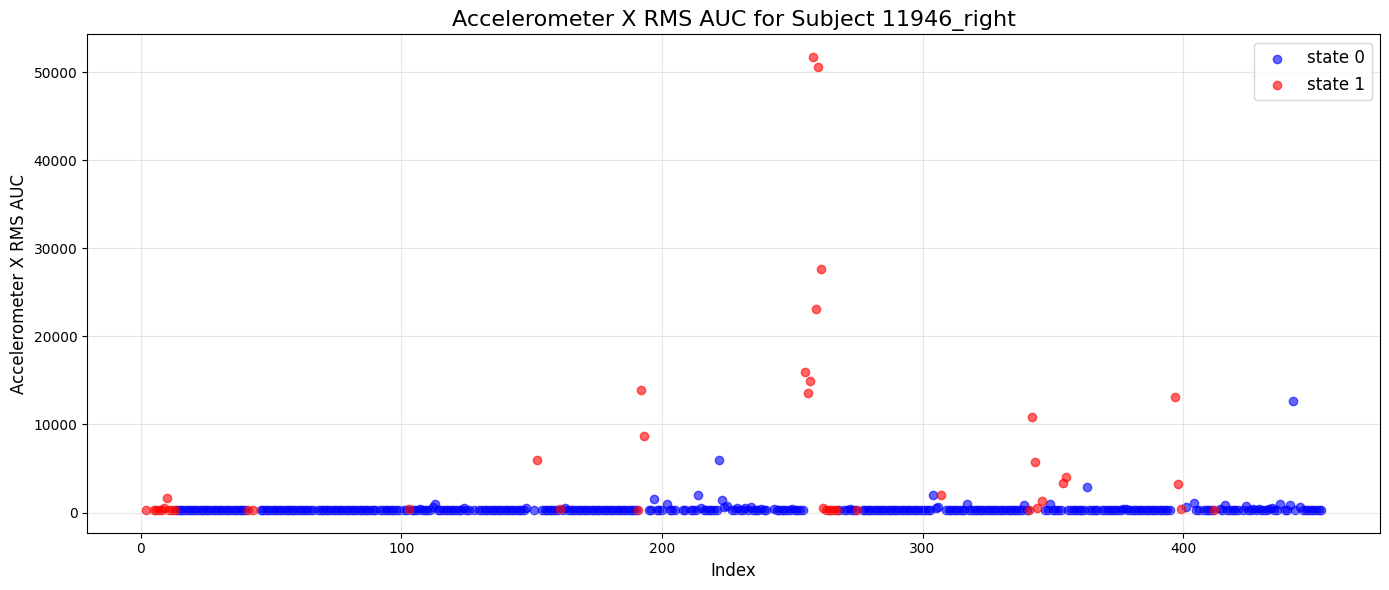

In [92]:
# Define the groups variable again
groups = final_df_imputed['subject_id']

# Filter data for the selected subject
selected_subject_id = groups.iloc[0]
subject_data = final_df_imputed[final_df_imputed['subject_id'] == selected_subject_id]

# Plot the accelerometerX_rms_auc with different colors for arousal states
plt.figure(figsize=(14, 6))

# Scatter plot for Arousal 0
plt.scatter(
    subject_data[subject_data['state_category'] == 0].index,
    subject_data[subject_data['state_category'] == 0]['accelerometerX_rms_auc'],
    color='blue', label='state 0', alpha=0.6
)

# Scatter plot for Arousal 1
plt.scatter(
    subject_data[subject_data['state_category'] == 1].index,
    subject_data[subject_data['state_category'] == 1]['accelerometerX_rms_auc'],
    color='red', label='state 1', alpha=0.6
)

# Add labels, title, and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Accelerometer X RMS AUC', fontsize=12)
plt.title(f'Accelerometer X RMS AUC for Subject {selected_subject_id}', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

### Exporting Processed Datasets

In [93]:
folder_name = f"{window_duration}"

# Create the folder if it doesn't exist
os.makedirs(folder_name, exist_ok=True)

# Save files inside the folder
final_df_imputed.to_csv(os.path.join(folder_name, f'final_df_imputed_{window_duration}.csv'), index=False)
final_df_imputed.to_pickle(os.path.join(folder_name, f'final_df_imputed_{window_duration}.pkl'))

df_acc_gyro.to_csv(os.path.join(folder_name, f'acc_gyro_data_{window_duration}.csv'), index=False)
df_acc_gyro.to_pickle(os.path.join(folder_name, f'acc_gyro_data_{window_duration}.pkl'))

print(f"Files saved inside '{folder_name}' folder.")

Files saved inside '60' folder.
